In [199]:
import os

import random
import logging
import argparse
from time import time

import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.distributed as dist

from model.TKGAT import TKGAT
from utility.parser_tkgat import *
from utility.log_helper import *
from utility.metrics import *
from utility.helper import *
from utility.loader_tkgat import DataLoaderTKGAT
from torch.utils.checkpoint import checkpoint
from main_tkgat import *
import dgl
from matplotlib import pyplot as plt
import matplotlib
from sklearn.preprocessing import normalize
%matplotlib inline

plt.rc('text', usetex=False)
plt.rc('font', size=18)
# params= {'text.latex.preamble' : [r'\usepackage{amsmath}']}
# plt.rcParams.update(params)

In [54]:
args_string = '--data_name movielens --gpu 1 --test'
args = parse_tkgat_args(args=args_string.split())

In [119]:
# GPU / CPU
use_cuda = torch.cuda.is_available()
device = torch.device(f"cuda:{args.gpu}" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
if n_gpu > 0:
    torch.cuda.manual_seed_all(args.seed)

# load data
data_loader = DataLoaderTKGAT(args, logging)
K = np.arange(args.K) + 1

# load model
model = TKGAT(args, data_loader.n_users, data_loader.n_entities, data_loader.n_relations, device=device)
model = load_model(model, get_best_model(args.save_dir))
print(f'Loaded {get_best_model(args.save_dir)}')
model.to(device)

# if use_cuda:
#     train_graph = data_loader.train_graph.to(device)

Loaded trained_model/TKGAT/movielens/entitydim100_relationdim50_attdim50_bi-interaction_100-50-25_lr0.001_pretrain1_atthead5/model_epoch37.pth


TKGAT(
  (relation_embed): Embedding(26460, 50)
  (entity_user_embed): Embedding(137372, 100)
  (aggregator_layers): ModuleList(
    (0): Aggregator(
      (message_dropout): Dropout(p=0.1, inplace=False)
      (W1): Linear(in_features=100, out_features=20, bias=True)
      (W2): Linear(in_features=100, out_features=20, bias=True)
      (activation): LeakyReLU(negative_slope=0.01)
    )
    (1): Aggregator(
      (message_dropout): Dropout(p=0.1, inplace=False)
      (W1): Linear(in_features=100, out_features=10, bias=True)
      (W2): Linear(in_features=100, out_features=10, bias=True)
      (activation): LeakyReLU(negative_slope=0.01)
    )
    (2): Aggregator(
      (message_dropout): Dropout(p=0.1, inplace=False)
      (W1): Linear(in_features=50, out_features=5, bias=True)
      (W2): Linear(in_features=50, out_features=5, bias=True)
      (activation): LeakyReLU(negative_slope=0.01)
    )
  )
)

In [120]:
def binary_hit(cf_scores, train_user_dict, test_user_dict, user_ids, item_ids):
    """
    cf_scores: (n_eval_users, n_eval_items)
    """
    test_pos_item_binary = np.zeros([len(user_ids), len(item_ids)], dtype=np.float32)
    for idx, u in enumerate(user_ids):
        train_pos_item_list = train_user_dict[u]
        test_pos_item_list = test_user_dict[u]
        cf_scores[idx][train_pos_item_list] = 0
        test_pos_item_binary[idx][test_pos_item_list] = 1

    try:
        _, rank_indices = torch.sort(cf_scores.cuda(), descending=True)    # try to speed up the sorting process
    except:
        _, rank_indices = torch.sort(cf_scores, descending=True)
    rank_indices = rank_indices.cpu()

    binary_hit = []
    for i in range(len(user_ids)):
        binary_hit.append(test_pos_item_binary[i][rank_indices[i]])
    binary_hit = np.array(binary_hit, dtype=np.float32)
    return binary_hit, rank_indices

In [121]:
user_ids = list(data_loader.test_user_dict.keys())
item_ids = torch.arange(data_loader.n_items, dtype=torch.long)
cf_scores = torch.tensor(np.load(os.path.join(args.save_dir, 'cf_scores.npy')))
hits, ranks = binary_hit(cf_scores, data_loader.train_user_dict, data_loader.test_user_dict, user_ids, item_ids)

In [122]:
K = 20
N = 10
precision_per_user = hits[:, :K].mean(axis=1)
topN_users_id = np.argsort(precision_per_user)[-1:-N-1:-1]
print(hits.shape)
print(topN_users_id)
print(precision_per_user[topN_users_id])

(2113, 10109)
[1468 1371 1476  869  169 1897 1913 1478 1455 1395]
[0.9  0.9  0.85 0.85 0.85 0.8  0.8  0.8  0.8  0.8 ]


In [123]:
def construct_full_graph(data_loader, heads, tails, relation):
    data = {'h': [], 't': [], 'r': []}
    for i, head in enumerate(heads):
        for tail in tails[i, :]:
            data['h'].append(head)
            data['t'].append(tail)
            data['r'].append(relation)
    data = pd.DataFrame.from_dict(data)
    graph = dgl.DGLGraph()
    graph.add_nodes(data_loader.n_entities)
    graph.add_edges(data['t'], data['h'])
    graph.ndata['id'] = torch.arange(data_loader.n_entities, dtype=torch.long)
    graph.edata['type'] = torch.LongTensor(data['r'])

    return graph

In [124]:
################ Case Study 1 #####################
N_items = 5
ranks = np.asarray(ranks)
item_id_recommend = ranks[topN_users_id, :N_items]
item_id_less_recommend = ranks[topN_users_id, -N_items:]
item_id_test = np.concatenate([item_id_recommend, item_id_less_recommend], axis=1)
print(item_id_test.shape)
print(item_id_test)

rows = topN_users_id.reshape([1, -1])[np.zeros(N_items*2, dtype=int), :].T
cols = item_id_test

cf_scores_np = np.asarray(cf_scores)
cf_scores_norm = (cf_scores_np - cf_scores_np.min(axis=1).reshape([-1,1])) / cf_scores_np.ptp(axis=1).reshape([-1,1])
cf_scores_show = cf_scores_norm[rows, cols]
print(cf_scores_show)
test_graph = construct_full_graph(data_loader, topN_users_id, item_id_test, 0) # relation #0 is 'interaction'

(10, 10)
[[ 3121  2350  1505  4120  2614  6504  6047  3472 10067   793]
 [  438  2671  7597  1138  8650  6487  3620 10067  8675  3472]
 [ 3146  3256  1738  1181  1730  7060  9678  6504 10021  5286]
 [ 5972  5675  6989  5027  5940  8675  8464  5136  4485   793]
 [ 5093  1144  1958  4998  5976  9990  5833  3909  3472  6504]
 [ 9351  8697  6720   306  9256  8675  3909  3472  4485  6504]
 [  828   846  2044  3584  1885  9990  5444  6504   598  7060]
 [ 4633  9207  8809  6660  9115  5790  6236  7444  6504  3068]
 [ 1078  1119  1193   944  1024  7560  9978  3923  3472  6504]
 [  722   566  1501  5027  2478  9459  3472  2376   793  6504]]
[[1.0000000e+00 9.9622166e-01 9.9565214e-01 9.9556047e-01 9.9429494e-01
  6.2702030e-02 6.1754521e-02 5.3718828e-02 3.8566101e-02 0.0000000e+00]
 [1.0000000e+00 9.9031574e-01 9.8683113e-01 9.7830439e-01 9.7524559e-01
  4.0335149e-02 3.8262963e-02 3.0027501e-02 2.9098481e-02 0.0000000e+00]
 [1.0000000e+00 9.7617036e-01 9.6085209e-01 9.5378578e-01 9.3638730e-0

/home/haoqing18/anaconda3/envs/pytorch/lib/python3.7/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


In [125]:
model.eval()
with torch.no_grad():
    att = model('calc_att', test_graph.to(device))
print(att.shape)

/home/haoqing18/anaconda3/envs/pytorch/lib/python3.7/site-packages/dgl/core.py:79: DGLWarning: The input graph for the user-defined edge function does not contain valid edges
  dgl_warning('The input graph for the user-defined edge function ' \


torch.Size([100, 5, 1])


tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000]])


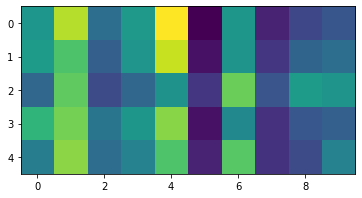

In [133]:
att = att.reshape([N, -1, 5]).cpu()
# print(att)
print(att.sum(axis=1))
plt.imshow(att[0, ...].T)

In [236]:
# save att & cf_scores
np.save('./case_study/attention_users.npy', att)
np.save('./case_study/cf_scores_users.npy', cf_scores_show)
np.save('./case_study/movie_ids.npy', item_id_test)
np.save('./case_study/user_ids.npy', topN_users_id)

In [ ]:
# load att & cf_scores
att = np.load('./case_study/attention_users.npy')
cf_scores_show = np.load('./case_study/cf_scores_users.npy')
item_id_test = np.load('./case_study/movie_ids.npy')
topN_users_id = np.load('./case_study/user_ids.npy')

In [254]:
# draw
def draw_user(fig, cf_scores, att, movie_names, user_org_id):
    gs = matplotlib.gridspec.GridSpec(2,2, height_ratios=[5,1], width_ratios=[14,1], wspace=0.01)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_ylabel(f'User #{user_org_id}')
    ax1.set_xticks(list(range(10)), labels=movie_names)
    ax1.set_yticks(list(range(5)), labels=[f'Head {i}' for i in range(5)])
    ax1.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
    plt.setp(ax1.get_xticklabels(), rotation=30, rotation_mode="anchor", ha='left')
    p1 = plt.imshow(att)

    ax2 = fig.add_subplot(gs[1, 0])
    ax2.set_xticks([])
    ax2.set_yticks([0] ,labels=['Score'])
    p2 = plt.imshow(cf_scores)

    colorAx1 = fig.add_subplot(gs[0, 1])
    plt.colorbar(p1, cax=colorAx1)
    colorAx2 = fig.add_subplot(gs[1, 1])
    plt.colorbar(p2, cax=colorAx2)

In [270]:
movie_file_path = './datasets/hetrec2011-movielens-2k-v2/movies.dat'
movie_names_org_id = {}
with open(movie_file_path, mode='r') as f:
    for line in f.readlines()[1:]:
        items = line.split('\t')
        org_id, name = items[:2]
        movie_names_org_id[int(org_id)] = name

movie_remap_file_path = './datasets/movielens/item_list.txt'
movie_id_o2r = {}
with open(movie_remap_file_path, mode='r') as f:
    for line in f.readlines()[1:]:
        org_id, remap_id = line.split()
        movie_id_o2r[int(org_id)] = int(remap_id)

movie_names_remap_id = {}
for org_id, name in movie_names_org_id.items():
    if org_id in movie_id_o2r:
        if name == 'Star Wars: Episode V - The Empire Strikes Back': name = 'Star Wars: Episode V'
        if name == 'The Lord of the Rings: The Return of the King': name = 'The Lord of the Rings'
        if name == 'Star Wars: Episode II - Attack of the Clones': name = 'Star Wars: Episode II'
        movie_names_remap_id[movie_id_o2r[org_id]] = name

print(len(movie_names_remap_id))

10109


In [250]:
user_id_file_path = './datasets/movielens/user_list.txt'
user_id_r2o = {}
with open(user_id_file_path, mode='r') as f:
    for line in f.readlines()[1:]:
        org_id, remap_id = line.split()
        user_id_r2o[int(remap_id)] = int(org_id)
print(len(user_id_r2o))

2113


In [268]:
def movie_id2name(movie_ids):
    return [movie_names_remap_id[movie_id] for movie_id in movie_ids]

# def user_id2org(user_ids):
#     return [user_id_r2o[user_id] for user_id in user_ids]

In [241]:
print(movie_id2name(item_id_test[0, :]))

['Erin Brockovich', 'Never Been Kissed', 'Sliding Doors', 'Legally Blonde', 'American Beauty', 'Girlhood', 'Que la bête meure', 'Project Moon Base', 'Yoru no onnatachi', 'Ai qing wan sui']


In [248]:
figsize = (9,5)

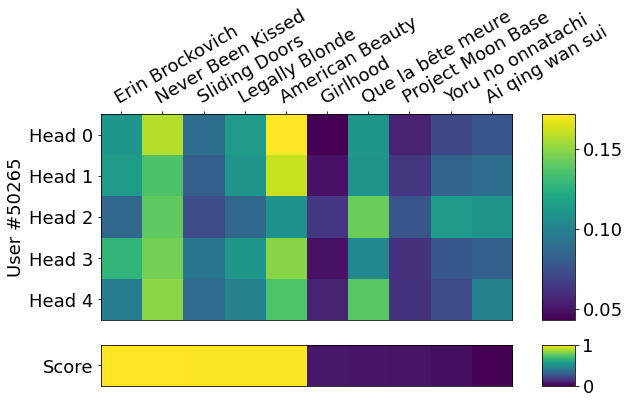

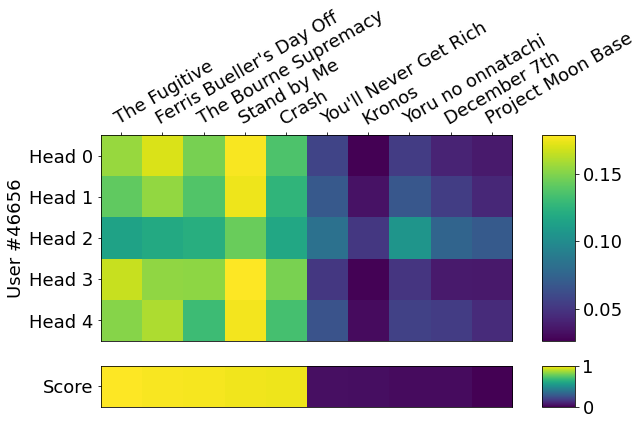

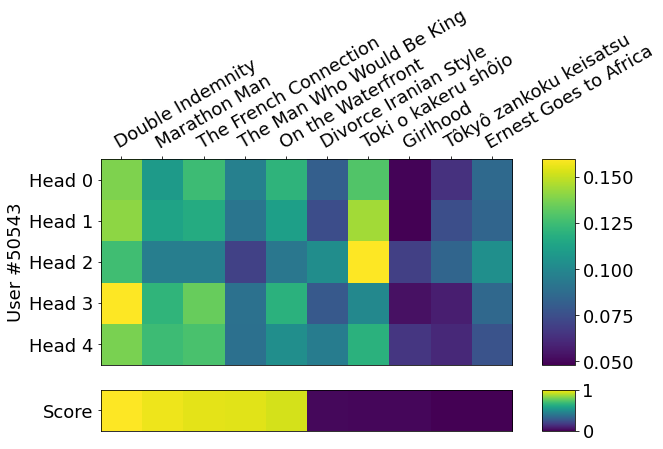

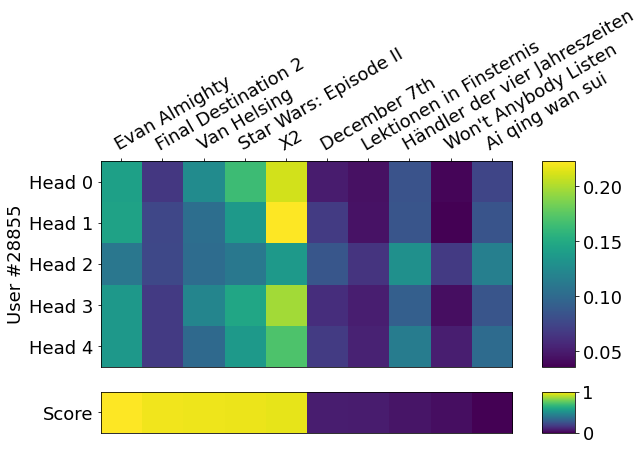

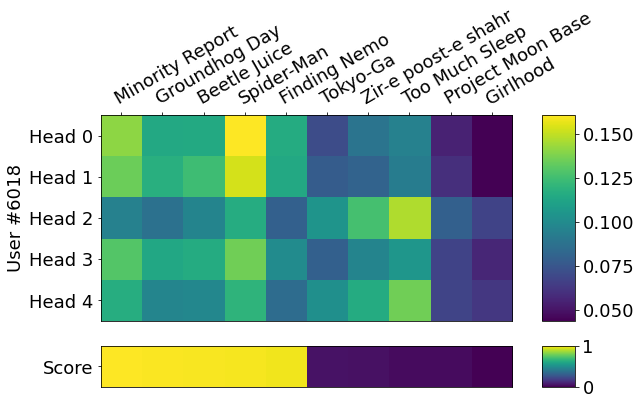

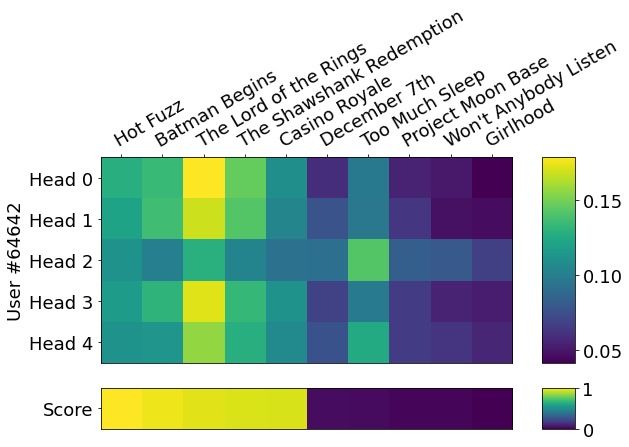

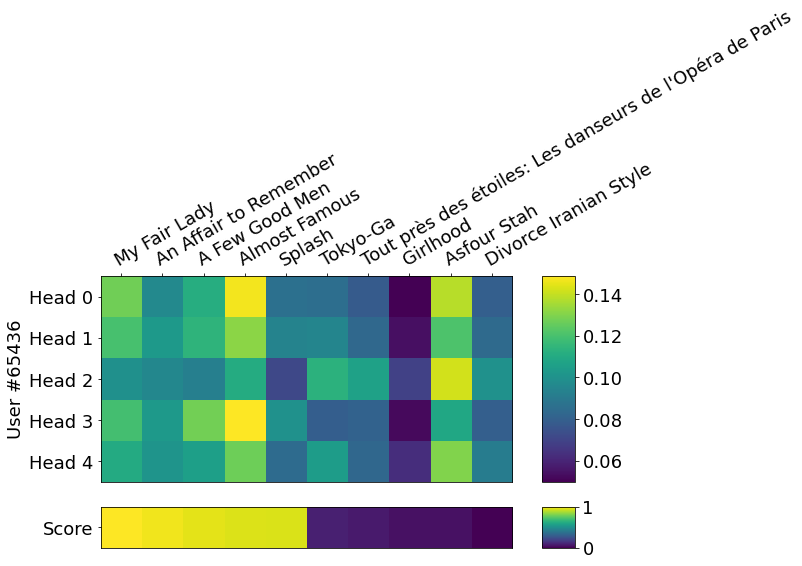

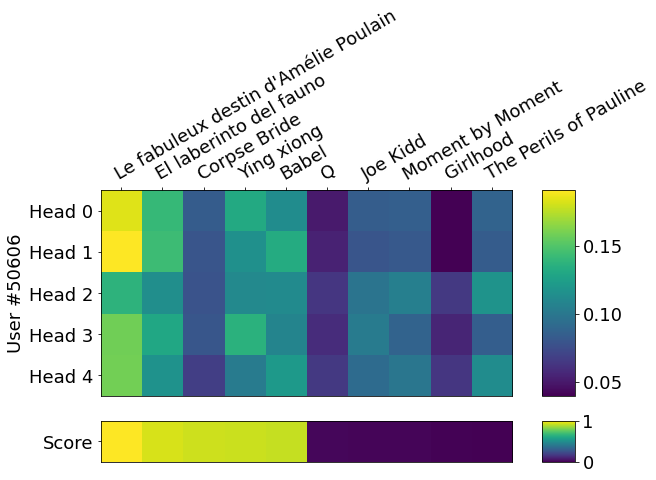

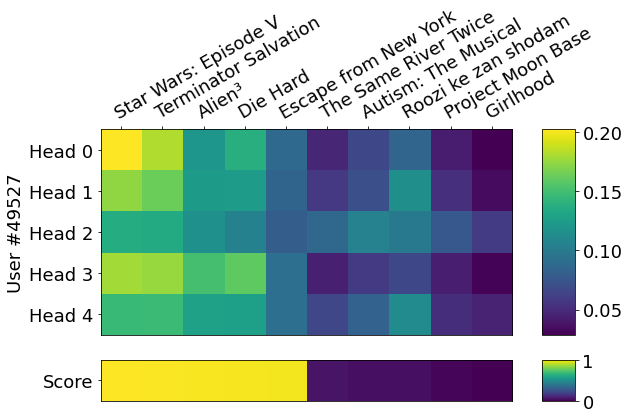

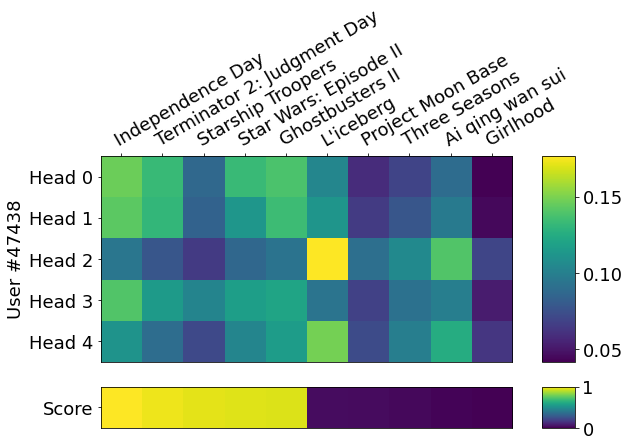

In [271]:
for i, user_id in enumerate(topN_users_id):
    fig = plt.figure(figsize=figsize)
    draw_user(fig, cf_scores_show[i, None, :], att[i, ...].T, movie_id2name(item_id_test[i, :]), user_id_r2o[user_id])
    plt.savefig(f'./case_study/fig/User{user_id_r2o[user_id]}.pdf',format='pdf',bbox_inches = 'tight')
    plt.show()

In [262]:
################## Case Study 2 ######################
import collections

movie_tag_file_path = './datasets/hetrec2011-movielens-2k-v2/movie_tags.dat'
movie_tag_count_full_orgid = collections.defaultdict(dict)
movie_tag_count_orgid = collections.defaultdict(int)
with open(movie_tag_file_path, mode='r') as f:
    for line in f.readlines()[1:]:
        movie_org_id, tag_org_id, times = line.split()
        movie_tag_count_full_orgid[int(movie_org_id)][int(tag_org_id)] = int(times)
        movie_tag_count_orgid[int(movie_org_id)] += int(times)
print(len(movie_tag_count_orgid))

7155


In [265]:
# select top-N movies
movie_tag_rank = sorted(movie_tag_count_orgid.keys(), key=movie_tag_count_orgid.get, reverse=True)
topN_movie_org_id = movie_tag_rank[:N]
movie_tag_count_rank_orgid = {}
for movie_id in topN_movie_org_id:
    movie_rank = sorted(movie_tag_count_full_orgid[movie_id].keys(), key=movie_tag_count_full_orgid[movie_id].get, reverse=True)
    movie_tag_count_rank_orgid[movie_id] = movie_rank[:5]


In [209]:
############### find top-K frequent tags ################
#### Only for dicts #####

dataset_dir = './datasets/hetrec2011-movielens-2k-v2'
interaction_file_name = 'user_taggedmovies.dat'
interaction_file_path = os.path.join(dataset_dir, interaction_file_name)

tag_file_name = 'tags.dat'
tag_file_path = os.path.join(dataset_dir, tag_file_name)

data = np.loadtxt(interaction_file_path, dtype=np.str_, skiprows=1, delimiter='\t')
tags = np.loadtxt(tag_file_path, dtype=np.str_, skiprows=1, delimiter='\t')

unique, counts = np.unique(data[:, 2], return_counts=True)
top_K_tag_org_id = list(map(int, unique[np.argsort(counts)[-1:-20:-1]]))
# print(counts[np.argsort(counts)[-1:-20:-1]])

tag_file_processed_path = './datasets/movielens/tag_list.txt'
tag_id_map_o2r = {}
tag_description_org_id = {}
with open(tag_file_processed_path, mode='r') as f:
    for line in f.readlines()[1:]:
        org_id, tag_id, description = line.split('\t')
        tag_id_map_o2r[int(org_id)] = int(tag_id)
        tag_description_org_id[int(org_id)] = description.strip()
top_K_tag_remap_id = list(map(lambda x: tag_id_map_o2r[x], top_K_tag_org_id))
top_K_tag_description = list(map(lambda x: tag_description_org_id[x], top_K_tag_org_id))
# for i, des in enumerate(top_K_tag_description):
#     print(i, des)

selected_idx = [1, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 17, 18]
selected_tag_org_id = np.asarray(top_K_tag_org_id)[selected_idx]
selected_tag_remap_id = np.asarray(top_K_tag_remap_id)[selected_idx]
selected_tag_description = list(map(lambda x: tag_description_org_id[x], selected_tag_org_id))
print(selected_tag_description)

['classic', 'oscar (best picture)', 'bibliothek', 'adapted from:book', 'atmospheric', 'criterion', 'seen more than once', 'stylized', 'action', 'scifi', 'quirky', 'dvd', 'tense', 'anime']


In [33]:
# choose words
word_entity_id = {entity: id for id, entity in enumerate(data_loader.word_entities)}
selected_tag_words = list(map(lambda x: data_loader.tag_description[x], selected_tag_remap_id))
selected_words = np.concatenate(selected_tag_words)
random_words = np.random.choice(data_loader.word_entities, size=13, replace=False)
chosen_words = np.concatenate((selected_words, random_words))
chosen_words_id = np.asarray(list(map(lambda x: word_entity_id[x], chosen_words)))
print(chosen_words)

['classic' 'oscar' 'bibliothek' 'adapted' 'atmospheric' 'criterion' 'seen'
 'more' 'than' 'once' 'stylized' 'action' 'scifi' 'quirky' 'dvd' 'tense'
 'anime' 'cave' 'dotrice' 'backwoods' 'olmos' 'constance' 'comes'
 'brittany' 'bonita' 'longest' 'club' 'zebra' 'survive' 'stunning']


In [266]:
movie_tag_count_rank_remap_id = {movie_id_o2r[movie_id]: [tag_id_map_o2r[tag_id] for tag_id in tag_ranks] for movie_id, tag_ranks in movie_tag_count_rank_orgid.items()}
print(movie_tag_count_rank_remap_id)

{285: [297, 2008, 354, 250, 479], 306: [160, 176, 561, 2080, 663], 2711: [86, 149, 696, 567, 144], 6920: [56, 237, 264, 347, 349], 508: [224, 154, 1012, 233, 585], 522: [246, 349, 1121, 145, 2126], 2340: [349, 164, 21, 449, 630], 249: [349, 133, 1121, 134, 561], 782: [561, 201, 289, 2117, 584], 6720: [134, 233, 517, 954, 540]}
